In [1]:
from sklearn.neighbors import kneighbors_graph
from sklearn.datasets import load_iris
from sklearn import tree
import sklearn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
%matplotlib inline
import numpy as np
from util import * 

In [2]:
data = np.genfromtxt('data/3blobs.data.csv',delimiter=',')
target = pd.read_csv('data/3blobs.cols.csv',header=None).to_numpy().flatten()
target_dict ={v:c for v,c in zip(np.unique(target),['#4E79A7','#F28E2B','#59A14F'])}
target = np.array([target_dict[t] for t in target])

In [3]:
target[target=='#4E79A7'].shape, target[target=='#F28E2B'].shape, target[target=='#59A14F'].shape

((100,), (200,), (500,))

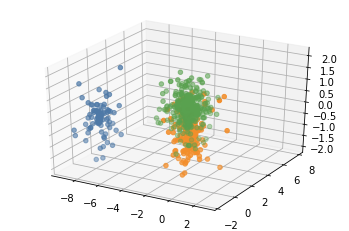

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(data[:,0], data[:,1], data[:,2], c=target)

In [5]:
unique, target = np.unique(target,return_inverse=True)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data, target)
sklearn.metrics.accuracy_score(target, clf.predict(data))

1.0

In [14]:
# import shap
# explainer = shap.TreeExplainer(clf)
# exp = explainer.shap_values(data,check_additivity=False)[0]

# we use the decision tree paths for each input as the explanation.
exp = clf.decision_path(data).A

noise = np.random.normal(0,1,exp.shape) * 0.1 # add some noises
exp = exp.astype('float') + noise

In [18]:
import kmapper as km
import networkx as nx
from collections import defaultdict
from scipy.cluster.hierarchy import linkage,fcluster

def remove_graph_duplicates(graph):
    unique_nodes = defaultdict(list)
    nodes = list(graph['nodes'].keys())
    dist = []
    for i,n1 in enumerate(nodes):
        for n2 in enumerate(nodes[i+1:]):
            dist.append(1-jaccard_similarity(n1,n2))
    Z = linkage(dist,'single')
    labels = fcluster(Z,0.1,'distance')
    for label, node in zip(labels,nodes):
        unique_nodes[label].append(node)
#     for key,val in graph['nodes'].items():
#         unique_nodes[frozenset(val)].append(key)

    unique_nodes = {val[0]:val[1:] for val in unique_nodes.values()}
    for val in unique_nodes.values():
        for node in val:
            del graph['nodes'][node]

    nodes_lookup = {}
    for key,val in unique_nodes.items():
        nodes_lookup[key] = key
        for v in val:
            nodes_lookup[v] = key

    unique_edges = defaultdict(set)
    for key,edges in graph['links'].items():
        key = nodes_lookup[key]
        edges = set([nodes_lookup[e] for e in edges])
        edges.discard(key)
        unique_edges[key] = unique_edges[key].union(edges)
    for key in list(unique_edges.keys()):
        if len(unique_edges[key]) == 0:
            del unique_edges[key]
        else:
            unique_edges[key] = list(unique_edges[key])
    graph = {'nodes':graph['nodes'],'links':unique_edges}
    return graph

def getGraph(data,exp,clusterer_param,clusterer='knn',projection=True,cover=[10, 0.1]):
    
    mapper = km.KeplerMapper(verbose=0)

    if clusterer == 'knn':
        A = kneighbors_graph(data, clusterer_param, mode='connectivity', include_self=True)
        clusterer = knnGraph(A)
        data = np.arange(data.shape[0]).reshape(-1,1)
    else:
        clusterer = sklearn.cluster.DBSCAN(eps=clusterer_param, min_samples=1) 

    if isinstance(projection, int):
        level_set = mapper.fit_transform(exp, projection=np.arange(projection).tolist())
        cover = km.Cover(cover[0],cover[1],[[np.float('inf'),np.float('inf')] for i in range(projection)])
    else:
        level_set = exp
        cover = km.Cover(cover[0],cover[1],[[np.float('inf'),np.float('inf')] for i in range(exp.shape[1])])
    graph = mapper.map(level_set,
                       data,
                       clusterer=clusterer,
                       cover=cover)
    return remove_graph_duplicates(graph)

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)

/Users/gromit/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/gromit/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/gromit/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/gromit/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.i

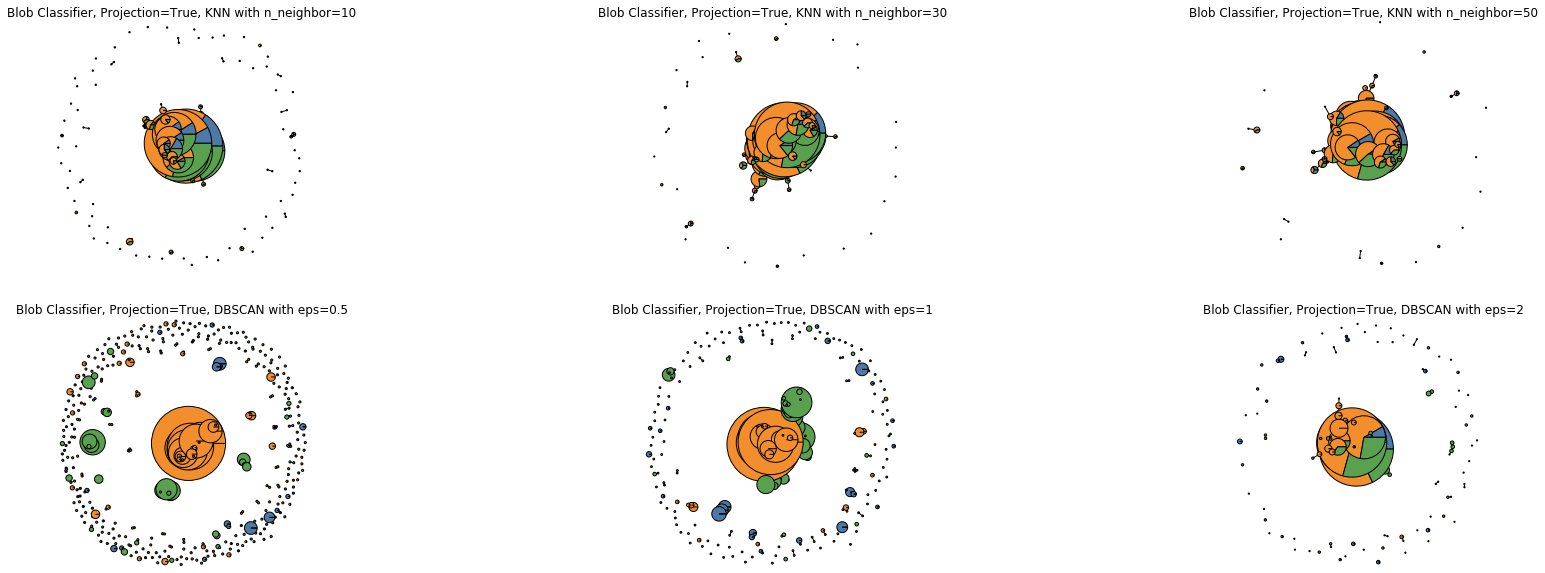

In [20]:
plt.rcParams['figure.facecolor'] = 'white'
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(30,10))

graph = getGraph(data,exp,10,'knn',projection=2)
drawGraph(ax1,graph,target,'Blob Classifier, Projection=True, KNN with n_neighbor=10')

graph = getGraph(data,exp,30,'knn',projection=2)
drawGraph(ax2,graph,target,'Blob Classifier, Projection=True, KNN with n_neighbor=30')

graph = getGraph(data,exp,100,'knn',projection=2)
drawGraph(ax3,graph,target,'Blob Classifier, Projection=True, KNN with n_neighbor=50')

graph = getGraph(data,exp,0.5,'dbscan',projection=2)
drawGraph(ax4,graph,target,'Blob Classifier, Projection=True, DBSCAN with eps=0.5')

graph = getGraph(data,exp,1,'dbscan',projection=2)
drawGraph(ax5,graph,target,'Blob Classifier, Projection=True, DBSCAN with eps=1')

graph = getGraph(data,exp,2,'dbscan',projection=2)
drawGraph(ax6,graph,target,'Blob Classifier, Projection=True, DBSCAN with eps=2')


/Users/gromit/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/gromit/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/gromit/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/gromit/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.i

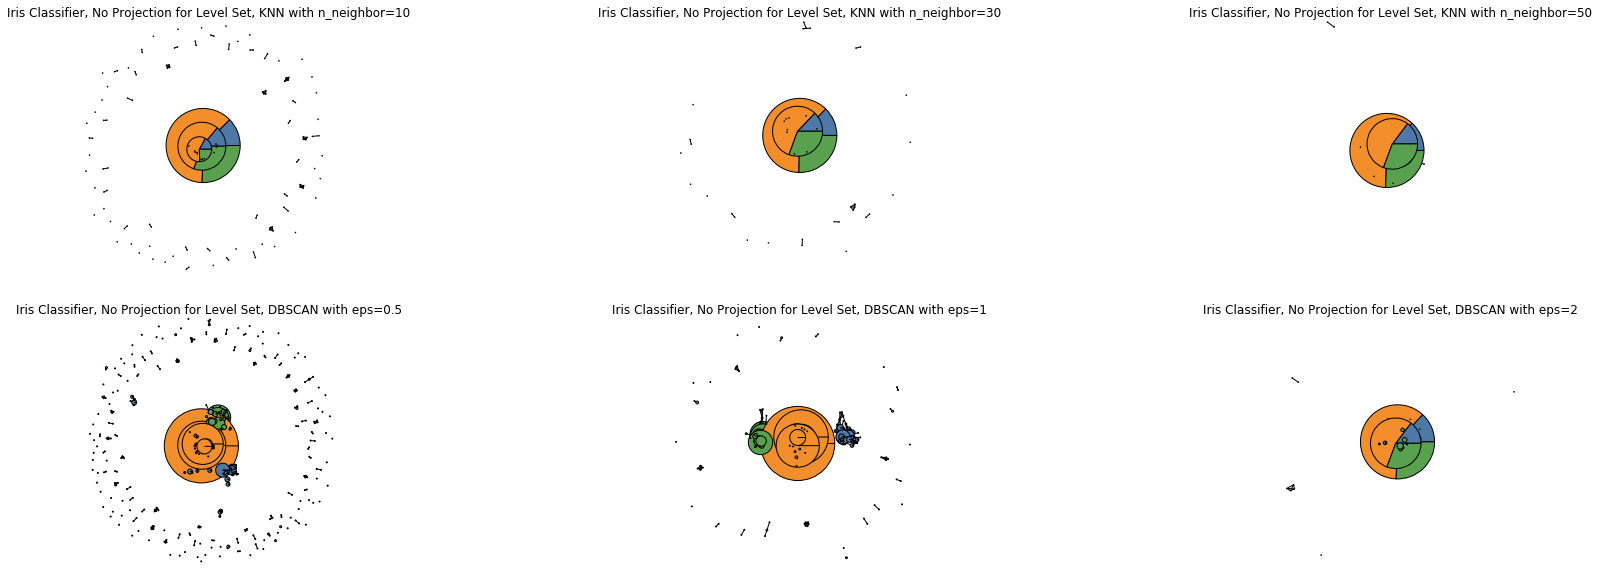

In [21]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(30,10))

graph = getGraph(data,exp,10,'knn',projection=None,cover=[2,0.1])
drawGraph(ax1,graph,target,'Iris Classifier, No Projection for Level Set, KNN with n_neighbor=10')

graph = getGraph(data,exp,30,'knn',projection=None,cover=[2,0.1])
drawGraph(ax2,graph,target,'Iris Classifier, No Projection for Level Set, KNN with n_neighbor=30')

graph = getGraph(data,exp,100,'knn',projection=None,cover=[2,0.1])
drawGraph(ax3,graph,target,'Iris Classifier, No Projection for Level Set, KNN with n_neighbor=50')

graph = getGraph(data,exp,0.5,'dbscan',projection=None,cover=[2,0.1])
drawGraph(ax4,graph,target,'Iris Classifier, No Projection for Level Set, DBSCAN with eps=0.5')

graph = getGraph(data,exp,1,'dbscan',projection=None,cover=[2,0.1])
drawGraph(ax5,graph,target,'Iris Classifier, No Projection for Level Set, DBSCAN with eps=1')

graph = getGraph(data,exp,2,'dbscan',projection=None,cover=[2,0.1])
drawGraph(ax6,graph,target,'Iris Classifier, No Projection for Level Set, DBSCAN with eps=2')